## Tahap 0 : Mempersiapkan Library

In [35]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot

import warnings
warnings.filterwarnings

%matplotlib inline

## Tahap 1 : Mempersiapkan data-data

In [6]:
df_customer = pd.read_csv('Customer.csv', delimiter=';')
df_product = pd.read_csv('Product.csv', delimiter=';')
df_store = pd.read_csv('Store.csv', delimiter=';')
df_transaction = pd.read_csv('Transaction.csv', delimiter=';')

In [11]:
df_customer.shape, df_product.shape, df_store.shape, df_transaction.shape

((447, 5), (10, 3), (14, 6), (5020, 8))

In [7]:
df_customer.head()

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,"5,12"
1,2,60,1,Married,"6,23"
2,3,32,1,Married,"9,17"
3,4,31,1,Married,"4,87"
4,5,58,1,Married,"3,57"


In [8]:
df_product.head()

,ProductID,Product Name,Price
0,P1,Choco Bar,8800
1,P2,Ginger Candy,3200
2,P3,Crackers,7500
3,P4,Potato Chip,12000
4,P5,Thai Tea,4200


In [9]:
df_store.head()

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,"-6,2","106,816666"
1,2,Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238"
2,3,Prima Kota,Prima,Modern Trade,"-7,797068","110,370529"
3,4,Gita Ginara,Gita,General Trade,"-6,966667","110,416664"
4,5,Bonafid,Gita,General Trade,"-7,250445","112,768845"


In [10]:
df_transaction.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1
2,TR1984,183,01/01/2022,P1,8800,4,35200,4
3,TR35256,160,01/01/2022,P1,8800,7,61600,4
4,TR41231,386,01/01/2022,P9,10000,1,10000,4


In [20]:
# Data Cleansing untuk DataFrame transaction
df_transaction['Date'] = pd.to_datetime(df_transaction['Date'])

# Data Cleansing untuk DataFrame customer
df_customer['Income'] = df_customer['Income'].replace('[,]','.', regex=True).astype('float')


# Data Cleansing untuk DataFrame store
df_store['Latitude'] = df_store['Latitude'].replace('[,]', '.', regex=True).astype('float')
df_store['Longitude'] = df_store['Longitude'].replace('[,]', '.', regex=True).astype('float')

/var/folders/gn/xs7s8thj773g8rfl8v4b6mtc0000gn/T/ipykernel_33819/3500859924.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_transaction['Date'] = pd.to_datetime(df_transaction['Date'])


In [26]:
df_transaction['Date'].dtype

dtype('<M8[ns]')

In [28]:
# Menggabungkan Data
df_merge = pd.merge(df_transaction, df_customer, on=['CustomerID'])
df_merge = pd.merge(df_merge, df_product.drop(columns=['Price']), on=['ProductID'])
df_merge = pd.merge(df_merge, df_store, on=['StoreID'])

In [29]:
df_merge.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,10.53,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,0.18,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,4.36,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
3,TR4331,335,2022-08-01,P3,7500,3,22500,12,29,1,Single,4.74,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
4,TR6445,181,2022-10-01,P3,7500,4,30000,12,33,1,Married,9.94,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554


In [31]:
df_regresi = df_merge.groupby(['Date']).agg({
    'Qty' : 'sum'
}).reset_index()

df_regresi

,Date,Qty
0,2022-01-01,49
1,2022-01-02,50
2,2022-01-03,76
3,2022-01-04,98
4,2022-01-05,67
...,...,...
360,2022-12-27,70
361,2022-12-28,68
362,2022-12-29,42
363,2022-12-30,44


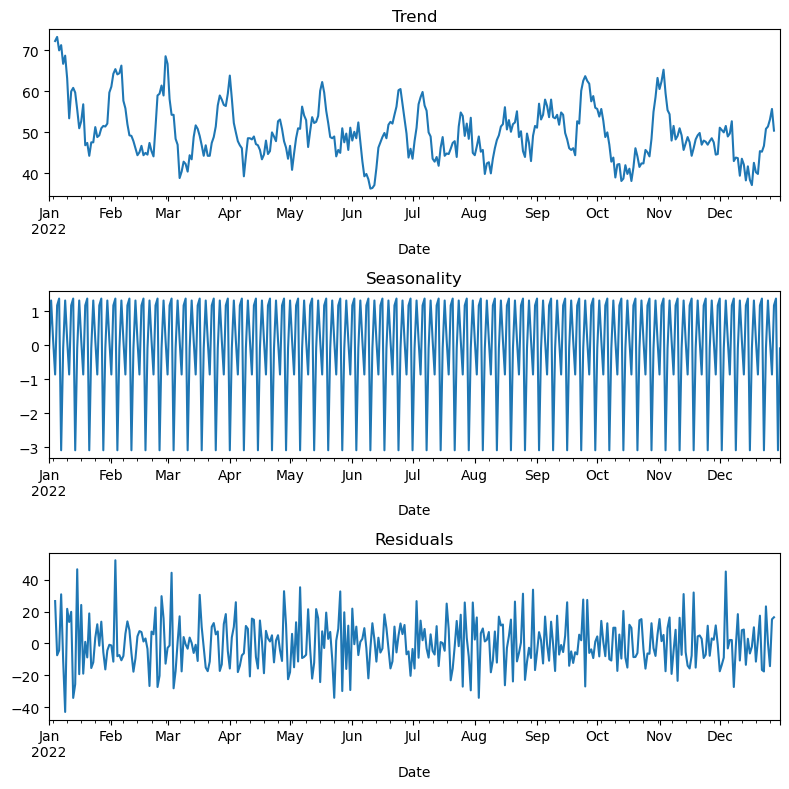

In [36]:
decomposed = seasonal_decompose(df_regresi.set_index('Date'))

plt.figure(figsize=(8, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

In [38]:
cut_off = round(df_regresi.shape[0] * 0.9)
df_train = df_regresi[:cut_off]
df_test = df_regresi[cut_off:].reset_index(drop=True)
df_train.shape, df_test.shape

((328, 2), (37, 2))

In [39]:
df_train

,Date,Qty
0,2022-01-01,49
1,2022-01-02,50
2,2022-01-03,76
3,2022-01-04,98
4,2022-01-05,67
...,...,...
323,2022-11-20,55
324,2022-11-21,55
325,2022-11-22,49
326,2022-11-23,40


In [41]:
df_test

,Date,Qty
0,2022-11-25,55
1,2022-11-26,40
2,2022-11-27,53
3,2022-11-28,50
4,2022-11-29,55
5,2022-11-30,45
6,2022-12-01,35
7,2022-12-02,34
8,2022-12-03,41
9,2022-12-04,98


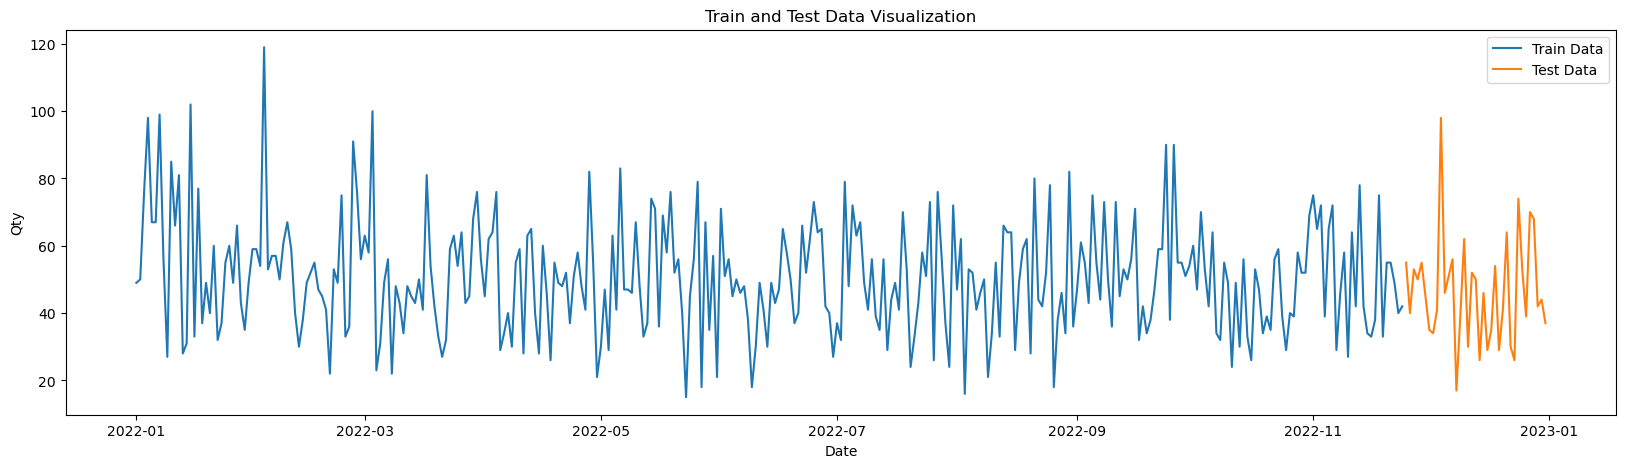

In [47]:
plt.figure(figsize=(20,5))
sns.lineplot(data=df_train, x='Date', y='Qty', label='Train Data');
sns.lineplot(data=df_test, x='Date', y='Qty', label='Test Data');

plt.xlabel('Date')
plt.ylabel('Qty')
plt.title('Train and Test Data Visualization')
plt.legend()  
plt.show()

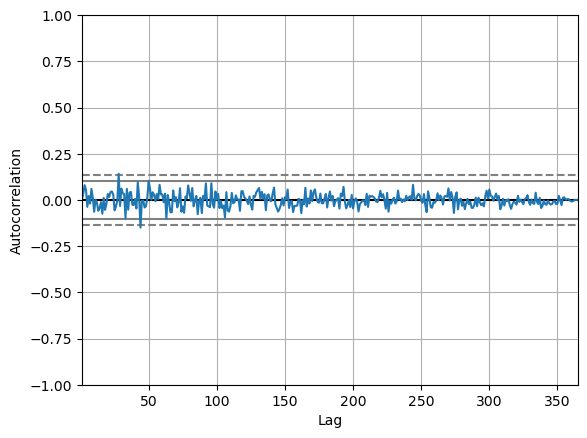

In [48]:
autocorrelation_plot(df_regresi['Qty']);

In [79]:
def rmse(y_actual, y_pred):
    print(f'RMSE value: {mean_squared_error(y_actual, y_pred)}')
          
def eval(y_actual, y_pred):
    rmse(y_actual, y_pred)
    
    print(f'MAE value: {mean_absolute_error(y_actual, y_pred)}')

/Users/imam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/imam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/imam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/imam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/imam/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarn

RMSE value: 255.6591271631385
MAE value: 12.440110689112547


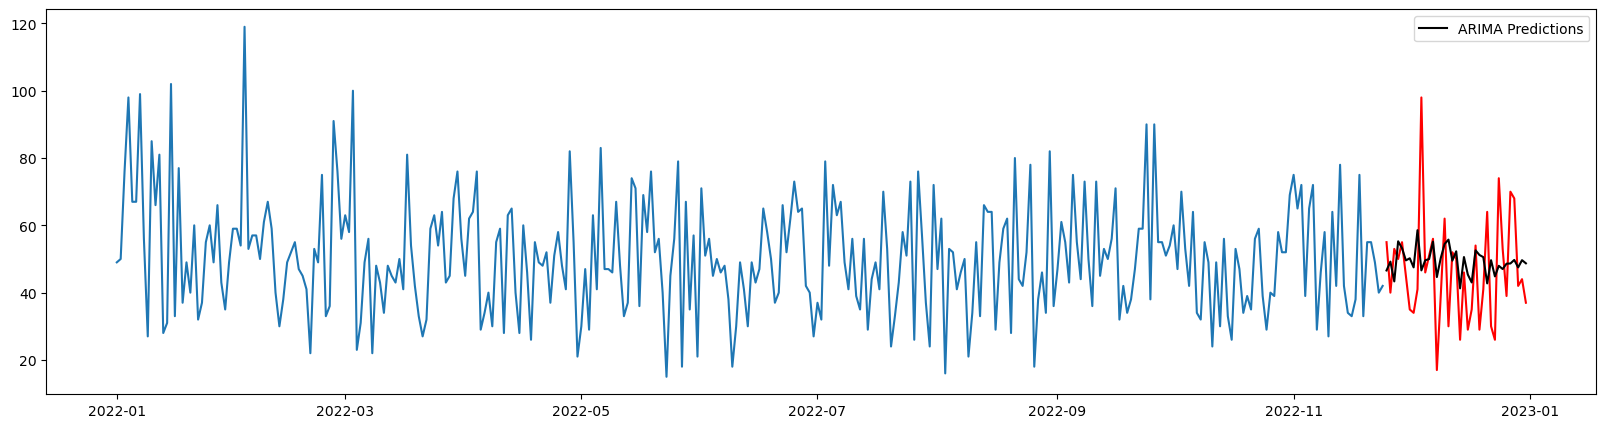

In [82]:
# ARIMA
y = df_train['Qty']

ARIMAmodel = ARIMA(y, order = (40, 2, 1))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(df_test))

y_pred_df = y_pred.conf_int()
y_pred_df['predictions'] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = df_test.index
y_pred_out = y_pred_df['predictions']
eval(df_test['Qty'], y_pred_out)

plt.figure(figsize=(20, 5))
plt.plot(df_train['Qty']);
plt.plot(df_test['Qty'], color='red');
plt.plot(y_pred_out, color='black', label='ARIMA Predictions' );
plt.legend()

In [57]:
df_merge.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,10.53,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,0.18,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,4.36,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
3,TR4331,335,2022-08-01,P3,7500,3,22500,12,29,1,Single,4.74,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
4,TR6445,181,2022-10-01,P3,7500,4,30000,12,33,1,Married,9.94,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554


In [58]:
df_merge.corr()

/var/folders/gn/xs7s8thj773g8rfl8v4b6mtc0000gn/T/ipykernel_33819/1139042121.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_merge.corr()


,CustomerID,Price,Qty,TotalAmount,StoreID,Age,Gender,Income,Latitude,Longitude
CustomerID,1.000000,-0.016423,-0.009755,-0.024915,0.004129,-0.025952,-0.009947,0.005783,0.002278,-0.003122
Price,-0.016423,1.000000,-0.353640,0.440632,-0.032863,0.014693,0.010705,0.001196,-0.029008,0.018652
Qty,-0.009755,-0.353640,1.000000,0.621129,0.014365,-0.027768,-0.010542,-0.028425,-0.004170,0.004807
TotalAmount,-0.024915,0.440632,0.621129,1.000000,-0.010722,-0.016900,-0.008774,-0.025350,-0.029938,0.025437
StoreID,0.004129,-0.032863,0.014365,-0.010722,1.000000,-0.003872,-0.000189,0.001613,0.471852,-0.094943
Age,-0.025952,0.014693,-0.027768,-0.016900,-0.003872,1.000000,-0.033183,0.486692,0.009266,0.015951
Gender,-0.009947,0.010705,-0.010542,-0.008774,-0.000189,-0.033183,1.000000,-0.071443,-0.006051,-0.001183
Income,0.005783,0.001196,-0.028425,-0.025350,0.001613,0.486692,-0.071443,1.000000,0.015518,0.004385
Latitude,0.002278,-0.029008,-0.004170,-0.029938,0.471852,0.009266,-0.006051,0.015518,1.000000,-0.395995
Longitude,-0.003122,0.018652,0.004807,0.025437,-0.094943,0.015951,-0.001183,0.004385,-0.395995,1.000000


In [60]:
df_cluster = df_merge.groupby(['CustomerID']).agg({
    'TransactionID' : 'count',
    'Qty' : 'sum'
}).reset_index()

In [63]:
df_cluster.head()

,CustomerID,TransactionID,Qty
0,1,17,60
1,2,13,57
2,3,15,56
3,4,10,46
4,5,7,27


In [64]:
df_cluster

,CustomerID,TransactionID,Qty
0,1,17,60
1,2,13,57
2,3,15,56
3,4,10,46
4,5,7,27
...,...,...,...
442,443,16,59
443,444,18,62
444,445,18,68
445,446,11,42


In [65]:
data_cluster = df_cluster.drop(columns=['CustomerID'])

data_cluster_normalize = preprocessing.normalize(data_cluster)

In [66]:
data_cluster_normalize

array([[0.27260257, 0.96212673],
       [0.22236034, 0.97496455],
       [0.25873609, 0.96594805],
       [0.21242964, 0.97717636],
       [0.25096216, 0.9679969 ],
       [0.2216211 , 0.97513286],
       [0.28580512, 0.95828776],
       [0.28547659, 0.95838568],
       [0.2216211 , 0.97513286],
       [0.26962993, 0.96296402],
       [0.24253563, 0.9701425 ],
       [0.25371269, 0.96727962],
       [0.26910454, 0.96311097],
       [0.32432432, 0.94594595],
       [0.26311741, 0.96476382],
       [0.25163385, 0.96782251],
       [0.25912857, 0.96584284],
       [0.30320366, 0.95292578],
       [0.23162053, 0.97280621],
       [0.27232247, 0.96220605],
       [0.27472113, 0.96152395],
       [0.26879897, 0.9631963 ],
       [0.26311741, 0.96476382],
       [0.29568373, 0.95528589],
       [0.28734789, 0.95782629],
       [0.30782029, 0.95144452],
       [0.29827499, 0.95447998],
       [0.28216632, 0.9593655 ],
       [0.23162053, 0.97280621],
       [0.24253563, 0.9701425 ],
       [0.

In [71]:
K = range(2, 8)
fits = []
score = []

for k in K:
    model = KMeans(n_clusters=k, random_state=0, n_init='auto').fit(data_cluster_normalize)
    
    fits.append(model)
    
    score.append(silhouette_score(data_cluster_normalize, model.labels_, metric='euclidean'))

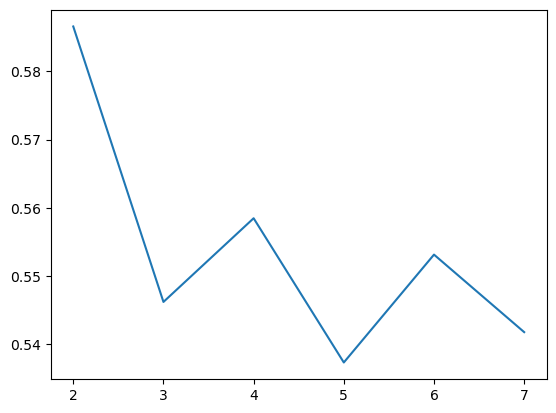

In [74]:
sns.lineplot(x = K, y = score);

In [77]:
df_cluster['cluster_label'] = fits[1].labels_

In [78]:
df_cluster.groupby(['cluster_label']).agg({
    'CustomerID' : 'count',
    'TransactionID' : 'mean',
    'Qty' : 'mean'
})

,CustomerID,TransactionID,Qty
cluster_label,,,
0,211,11.857820,42.644550
1,102,11.176471,32.637255
2,134,10.283582,44.544776
